This notebook is for the analysis of experiments in which some flies were interacting with balls that were blocked using magnets. After a certain amount of time, magnets were removed and we want to compare how well they push balls compared to controls.

# Required packages 


In [1]:
import sys
import os
from icecream import ic

from pathlib import Path

import utils_behavior

from utils_behavior import Ballpushing_utils
#from utils_behavior import Utils
from utils_behavior import Processing
from utils_behavior import HoloviewsTemplates
from utils_behavior import Seaborn_Templates
from utils_behavior import Sleap_utils
from utils_behavior import Processing
from utils_behavior import Utils

import pandas as pd
import hvplot.pandas
import numpy as np

from scipy import stats
from statsmodels.stats.multitest import multipletests

# from sklearn.decomposition import PCA
# from sklearn.preprocessing import StandardScaler
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

#import iqplot

import importlib

import holoviews as hv
import bokeh.io
import colorcet

bokeh.io.output_notebook()

hv.extension("bokeh")

Loading BallPushing utils version 10 Mar 2025


Loading BokehJS ...

In [ ]:
# Select the experiments to analyze

Let's start with one that is representative of the best settings I had, which was using magnets under the backlighting sheet, keeping control flies in their chambers until the first half-hour of pretraining was finished.
These were done on **240530 and 240531**

In [ ]:
# Get the data path
Datapath = Utils.get_data_path()

# Get all folders with "TNT_Fine" in the name

Folders = [
    f
    for f in os.listdir(Datapath)
    if "240530" in f or "240531" in f and os.path.isdir(Datapath / f)
]

Folders

In [ ]:
importlib.reload(Ballpushing_utils)

In [ ]:
# Generate Experiment objects from each folder

Experiments = [Ballpushing_utils.Experiment(Datapath / f, experiment_type = "MagnetBlock") for f in Folders]

In [ ]:
importlib.reload(Ballpushing_utils)

In [ ]:
# Build the position

magnet_data_summary = Ballpushing_utils.Dataset(Experiments, dataset_type="summary")

print(magnet_data_summary)

In [ ]:
Magnet_summary_dataset = magnet_data_summary.data

Magnet_summary_dataset

In [ ]:
magnet_data_summary.data.columns

In [ ]:
metrics_to_plot = ['nb_events', 'max_event', 'max_event_time', 'max_distance',
       'final_event', 'final_event_time', 'nb_significant_events',
       'significant_ratio', 'first_significant_event',
       'first_significant_event_time', 'aha_moment', 'aha_moment_time',
       'insight_effect', 'cumulated_breaks_duration', 'pushed', 'pulled',
       'pulling_ratio', 'success_direction', 'interaction_proportion',
       'distance_moved']

In [ ]:
importlib.reload(Seaborn_Templates)

In [ ]:
for metric in metrics_to_plot:
    try:
        Seaborn_Templates.sns_plot(magnet_data_summary.data, metric=metric, kdims="Magnet", colorby="Magnet", plot_type="jitterboxplot")
        
    except:
        print(f"Error with {metric}")
        
        



In [ ]:
start = 30 * 60

magnet_data.generate_dataset("summary", time_range=[start])

In [ ]:
# Get sample size : get how many unique fly ids we have grouped by Magnet

magnet_data.data.groupby("Magnet")["fly"].nunique()

# Create a "label" column that is "Magnet block" if Magnet is y, and "Control" if Magnet is n. Add the sample size to the label.

magnet_data.data["label"] = magnet_data.data["Magnet"].apply(
    lambda x: "Magnet block (n = 59)" if x == "y" else "Control (n = 48)"
)


In [ ]:
# Get the data columns

data_columns = magnet_data.data.columns

data_columns

# Do some plotting

Now we're gonna plot some metrics and compare them between Magnet y and magnet n.

In [ ]:
importlib.reload(HoloviewsTemplates)

In [ ]:
Plot = HoloviewsTemplates.jitter_boxplot(
    data=magnet_data.data,
    metric ="TimeToFinish",
    kdims = "label",
    metadata=magnet_data.metadata,
    plot_options=HoloviewsTemplates.hv_slides,
    colorby="Genotype",
)

In [ ]:
Plot = Plot.opts(
    ylabel = "Time to bring the ball to the end (s)",
    ylim = (0, 3800)
)

In [ ]:
Plot
# + Histogram distribution

## Make and save all metrics plots

In [ ]:
savepath = Utils.get_labserver() / "Experimental_data/MultiMazeRecorder/Plots/MagnetBlock/240617"

In [ ]:
hv.save(Plot, savepath / "TimeToFinish_byGenotype.html")

In [ ]:
# Also get the png
hv.save(Plot, savepath / "TimeToFinish_byGenotype.png", fmt="png")

In [ ]:
# Do the same with NumberEvents

Plot = HoloviewsTemplates.jitter_boxplot(
    data=magnet_data.data,
    metric="NumberEvents",
    kdims="label",
    metadata=magnet_data.metadata,
    plot_options=HoloviewsTemplates.hv_slides,
    colorby="Genotype",
)

Plot = Plot.opts(
    ylabel = "Number of events",
)

hv.save(Plot, savepath / "NumberEvents_byGenotype.html")

In [ ]:
# Generate the list of metrics

metrics = [
    "NumberEvents",
    "FinalEvent",
    "FinalTime",
    "SignificantEvents",
    "SignificantFirst",
    "SignificantFirstTime",
    "Pushes",
    "Pulls",
    "PullingRatio",
    "InteractionProportion",
    "AhaMoment",
    "AhaMomentIndex",
    "InsightEffect",
    "TimeToFinish",
    "SignificantRatio",
]

In [ ]:
# For each metric, generate a jitter boxplot and save it

for metric in metrics: 
    Plot = HoloviewsTemplates.jitter_boxplot(
        magnet_data.data, metric, "Magnet", magnet_data.metadata, scale_max=[True if metric == "FinalTime" else False]
    )
    hv.save(Plot, savepath / f"{metric}.html")

In [ ]:
# Make a nice layout with all the plots:
plots = []

for metric in metrics:
    Plot = HoloviewsTemplates.jitter_boxplot(
        magnet_data.data,
        metric,
        "Magnet",
        magnet_data.metadata,
        scale_max=[True if metric in ["FinalTime", "SignificantRatio"] else False],
    )
    plots.append(Plot)

layout = hv.Layout(plots).cols(2)

In [ ]:
hv.save(layout, savepath / "All_metrics.html")

In [ ]:
importlib.reload(HoloviewsTemplates)

# Distribution

We can see that there seems to be some distribution variability between groups, which would be better highlighted by using something like an histogram

In [ ]:
Hist = HoloviewsTemplates.histograms(magnet_data.data, "TimeToFinish", "label", bins = 20, xlabel = "Time to bring the ball to the end (s)", plot_options=HoloviewsTemplates.hv_slides, orientation = "horizontal")

In [ ]:
Hist

In [ ]:
hv.save(Hist, savepath / "TimeToFinish_histogram.png")

# Heatmaps

Let's look at the ball position over time grouped by Magnet condition

In [ ]:
importlib.reload(Ballpushing_utils)

In [ ]:
start = 30 * 60

In [ ]:
position = magnet_data.generate_dataset(metrics = "coordinates", time_range=[start])

## Sanity checks

> The dataset should be 3600 seconds long. So 3600 * 29 rows.

In [ ]:
position.head()

In [ ]:
# Get the data columns

data_columns = position.columns

data_columns

In [ ]:
import holoviews as hv
from holoviews import opts
from holoviews.plotting.util import process_cmap
from bokeh.palettes import Viridis256
from bokeh.models import FixedTicker
import dask.dataframe as dd

# Convert the DataFrame to a Dask DataFrame
ddf = dd.from_pandas(position, npartitions=4)  # Use a suitable number of partitions

# Convert 'Magnet' and 'time' to categorical data type
ddf["Magnet"] = ddf["Magnet"].astype("category")
ddf["time"] = ddf["time"].astype("category")

# Ensure that the categories of 'time' are known
ddf["time"] = ddf["time"].cat.as_known()

# Define custom colormap
cmap = process_cmap("Viridis256_r", provider="bokeh")

# Get unique genotypes
Genotypes = ddf["Magnet"].unique().compute()


# Define a function that removes y-axis ticks
def remove_yticks(plot, element):
    plot.handles["yaxis"].ticker = FixedTicker(ticks=[])


# Pivot the DataFrame once
df_pivot = ddf.categorize(["Magnet", "time"]).pivot_table(
    index="fly", columns="time", values="yball_relative", aggfunc="first"
)

for genotype in Genotypes:
    # Slice the pivoted DataFrame for the current genotype
    df_genotype = df_pivot.loc[ddf[ddf["Magnet"] == genotype]["fly"].unique()]

    # Create a HeatMap
    heatmap = hv.HeatMap((df_genotype.columns, df_genotype.index, df_genotype.values))

    # Apply options to the HeatMap
    heatmap.opts(
        opts.HeatMap(
            cmap=cmap,
            colorbar=True,
            tools=["hover"],
            width=900,
            height=900,
            title=genotype,
            xlabel="Time(s)",
            ylabel="",
            fontscale=1.5,
        )
    )

    # Save each plot as a separate file in SVG format
    hv.save(heatmap, f"{savepath}/heatmap_{genotype}.svg", fmt="svg")

In [ ]:
Plotlist[0]

In [ ]:
# Create a layout with all the plots
layout = hv.Layout(Plotlist).cols(2)

layout

In [ ]:
# Save the layout
hv.save(layout, savepath / "Heatmaps.html")

# New protocol

Here I'm gonna replicate the analysis with a new protocol where control flies get to explore part of the corridor and have a transparent gate to see the ball and so the gate lifting doesn't provide a clear cue that they can push now.

In [ ]:
importlib.reload(Ballpushing_utils)


In [ ]:
# Get the data path
Datapath = Utils.get_data_path()

# Get all folders with "TNT_Fine" in the name

Folders = [
    f
    for f in os.listdir(Datapath)
    if "240710" in f or "240711" in f and os.path.isdir(Datapath / f)
]

Folders

In [7]:
savepath = Utils.get_data_path() / "Experimental_data/MultiMazeRecorder/Plots/MagnetBlock/250512"

print(savepath)

# if the folder does not exist, create it

savepath.mkdir(parents=True, exist_ok=True)

/mnt/upramdya_data/MD/MultiMazeRecorder/Videos/Experimental_data/MultiMazeRecorder/Plots/MagnetBlock/250512


In [ ]:

# Generate Experiment objects from each folder

Experiments = [Ballpushing_utils.Experiment(Datapath / f, experiment_type="MagnetBlock") for f in Folders]

In [ ]:
importlib.reload(Ballpushing_utils)

In [ ]:
magnet_data_coords = Ballpushing_utils.Dataset(Experiments, dataset_type="coordinates")

In [ ]:
magnet_data_coords.data.head()

In [ ]:
# Save the data

# Rename the Magnet values to "Magnet block" and "Control" 

magnet_data_coords.data["label"] = magnet_data_coords.data["Magnet"].apply(lambda x: "Magnet block" if x == "y" else "Control")

magnet_data_coords.data.to_feather("/mnt/upramdya_data/MD/MagnetBlock/Datasets/250213_coordinates.feather")

In [2]:
# Load from feather


magnet_data_coords_data = pd.read_feather("/mnt/upramdya_data/MD/MagnetBlock/Datasets/250213_coordinates.feather")

In [5]:
# Make a downsampled version of the data, taking only every 290 rows based on the time column

magnet_data_coords_ds = magnet_data_coords_data.iloc[::290, :]

In [ ]:
importlib.reload(Processing)

In [18]:
bin_number = 10

# Prepare data for permutation test

binned_data = Processing.preprocess_data(magnet_data_coords_data, bins=bin_number, group_col="Magnet")

# Compute the permutation test

permutation = Processing.compute_permutation_test(binned_data, group_col= "Magnet", control_group="n", metric="avg_distance_ball_0", n_permutations=1000)

print (permutation["p_values_corrected"])

print(permutation["significant_timepoints"])
            
# Add the 'Significant' column to the preprocessed data
binned_data['Significant'] = binned_data['time_bin'].isin(permutation['significant_timepoints'])


[0.         0.295      0.81       0.81       0.975      0.81
 0.85333333 0.81       0.81       0.81      ]
[0]


In [20]:
# print p values with some more decimals

pvalues = permutation["p_values_corrected"]

pvalues = pd.Series(pvalues).apply(lambda x: f"{x:.4f}")

pvalues

0    0.0000
1    0.2950
2    0.8100
3    0.8100
4    0.9750
5    0.8100
6    0.8533
7    0.8100
8    0.8100
9    0.8100
dtype: object

In [12]:
# Map label to colors, with "Magnet block" as blue and "Control" as orange
label_colors = {
    "Magnet block": "blue",
    "Control": "orange"
}

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


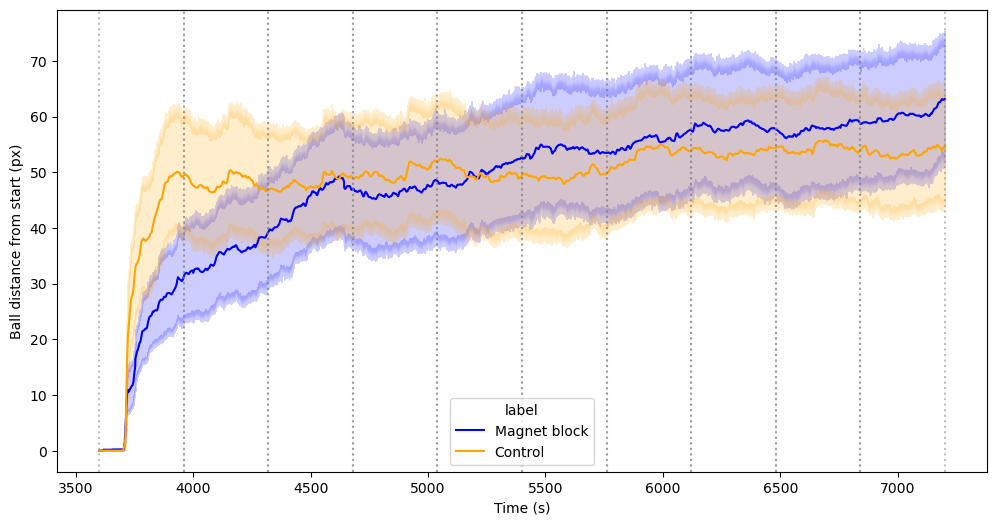

In [21]:

# Prepare figure

plt.figure(figsize=(12, 6))

# Plot the raw data
sns.lineplot(
    data=magnet_data_coords_data,
    x='time',
    y='distance_ball_0',
    hue='label',
    palette=label_colors
)
# Highlight significant timepoints with dotted lines and asterisks

significant_bins = binned_data[binned_data['Significant']]['time_bin']
for time_bin in range(bin_number):
    bin_start = magnet_data_coords_data['time'].min() + time_bin * (magnet_data_coords_data['time'].max() - magnet_data_coords_data['time'].min()) / bin_number
    bin_end = bin_start + (magnet_data_coords_data['time'].max() - magnet_data_coords_data['time'].min()) / bin_number
    
    # Draw faint dotted lines for the bins
    plt.axvline(bin_start, color='gray', linestyle='dotted', alpha=0.5)
    plt.axvline(bin_end, color='gray', linestyle='dotted', alpha=0.5)
    
    # Annotate significance levels
    if time_bin in significant_bins.values:
        p_value = permutation['p_values_corrected'][time_bin]
        if p_value < 0.001:
            significance = '***'
        elif p_value < 0.01:
            significance = '**'
        elif p_value < 0.05:
            significance = '*'
        else:
            significance = ''
        
        if significance:
            # Lower the y position of the stars and increase font size
            y_position = magnet_data_coords_data['distance_ball_0'].max() * 0.95
            plt.annotate(significance, xy=(bin_start + (bin_end - bin_start) / 2, y_position), 
                            xycoords='data', ha='center', va='bottom', fontsize=16, color='red')

# Adjust labels

plt.xlabel('Time (s)')

plt.ylabel('Ball distance from start (px)')
# plt.set_xlabel('Time (s)')
# plt.set_ylabel('Ball distance from start (px)')

# Save the plot

plt.savefig(savepath / "Ballpositions_curves_small.eps", format='eps')

plt.savefig(savepath / "Ballpositions_curves_signif_small.png")

plt.show()


In [ ]:
import pandas as pd

# Set your frame rate (frames per second)
frames_per_second = 29

# Sort by time to ensure correct rolling
magnet_data_coords_data = magnet_data_coords_data.sort_values('time')

# Apply rolling mean (window=frames_per_second), then sample every 290th row
magnet_data_coords_data['distance_ball_0_smooth'] = (
    magnet_data_coords_data.groupby('label')['distance_ball_0']
    .transform(lambda x: x.rolling(window=frames_per_second, min_periods=1).mean())
)

# Downsample: take every 290th frame
downsampled = magnet_data_coords_data.iloc[::frames_per_second, :]

# Now plot using the downsampled and smoothed data
plt.figure(figsize=(20, 10))
sns.lineplot(
    data=downsampled,
    x='time',
    y='distance_ball_0',
    hue='label',
    palette=label_colors
)

# Highlight significant timepoints with dotted lines and asterisks

significant_bins = binned_data[binned_data['Significant']]['time_bin']
for time_bin in range(bin_number):
    bin_start = downsampled['time'].min() + time_bin * (downsampled['time'].max() - downsampled['time'].min()) / bin_number
    bin_end = bin_start + (downsampled['time'].max() - downsampled['time'].min()) / bin_number
    
    # Draw faint dotted lines for the bins
    plt.axvline(bin_start, color='gray', linestyle='dotted', alpha=0.5)
    plt.axvline(bin_end, color='gray', linestyle='dotted', alpha=0.5)
    
    # Annotate significance levels
    if time_bin in significant_bins.values:
        p_value = permutation['p_values_corrected'][time_bin]
        if p_value < 0.001:
            significance = '***'
        elif p_value < 0.01:
            significance = '**'
        elif p_value < 0.05:
            significance = '*'
        else:
            significance = ''
        
        if significance:
            # Lower the y position of the stars and increase font size
            y_position = downsampled['distance_ball_0'].max() * 0.95
            plt.annotate(significance, xy=(bin_start + (bin_end - bin_start) / 2, y_position), 
                            xycoords='data', ha='center', va='bottom', fontsize=16, color='red')

# Adjust labels

plt.xlabel('Time (s)')

plt.ylabel('Ball distance from start (px)')
# plt.set_xlabel('Time (s)')
# plt.set_ylabel('Ball distance from start (px)')

# Save the plot

plt.savefig(savepath / "Ballpositions_curves_Down.eps", format='eps')

plt.savefig(savepath / "Ballpositions_curves_signif_Down.png")

plt.show()




In [ ]:

# Plot the coordinates with IC and with hue = Magnet

curves = sns.lineplot(
    data=magnet_data_coords.data,
    x="time",
    y="distance_ball_0",
    hue="Magnet",
)

# Save the plot

curves.get_figure().savefig(savepath / "Ballpositions_curves.png")
curves

In [ ]:
magnet_data_coords.head()

In [ ]:
# Rename the Magnet values to "Magnet block" and "Control" 

magnet_data_coords["label"] = magnet_data_coords["Magnet"].apply(lambda x: "Magnet block" if x == "y" else "Control")

In [ ]:
# Plot the average ball displacement grouped by Magnet

Lineplot = sns.lineplot(data=magnet_data_coords, x="time", y="distance_ball_0", hue="Magnet")

# Customize x, y and legend labels

Lineplot.set(xlabel="Time (s)", ylabel="Distance (px)", title="")

plt.savefig("/mnt/upramdya_data/MD/MultiMazeRecorder/Plots/MagnetBlock/241212Average_ball_displacement.png")

plt.show()


In [ ]:
importlib.reload(Ballpushing_utils)
importlib.reload(Sleap_utils)

In [ ]:
# Get the data path
Datapath = Utils.get_data_path()

# Get all folders with "TNT_Fine" in the name

Folders = [
    f
    for f in os.listdir(Datapath)
    if "240710" in f or "240711" in f and os.path.isdir(Datapath / f)
]

Folders

In [ ]:
# Build the position

magnet_data_summary = Ballpushing_utils.Dataset(Experiments, dataset_type="summary").data

In [ ]:
magnet_data_summary.to_feather("/home/durrieu/ballpushing_utils/outputs/MagnetBlock/magnet_data.feather")

In [ ]:
# Get the data columns
magnet_data_summary.columns

In [ ]:
metrics_to_plot = ['nb_events', 'max_event', 'max_event_time', 'max_distance',
       'final_event', 'final_event_time', 'nb_significant_events',
       'significant_ratio', 'first_significant_event',
       'first_significant_event_time', 'aha_moment', 'aha_moment_time',
       'insight_effect', 'cumulated_breaks_duration', 'pushed', 'pulled',
       'pulling_ratio', 'success_direction', 'interaction_proportion',
       'distance_moved']

In [ ]:
metrics_to_exclude = ["final_event", "final_event_time"]

In [ ]:
magnet_data_summary["final_event"]

In [ ]:
# Rename the Magnet values to "Magnet block" and "Control" 

magnet_data_summary["label"] = magnet_data_summary["Magnet"].apply(lambda x: "Magnet block" if x == "y" else "Control")

In [ ]:
# Define the metrics to plot
metrics = [
    "nb_events",
    "max_event",
    "max_event_time",
    "max_distance",
    "final_event",
    "final_event_time",
    "nb_significant_events",
    "significant_ratio",
    "first_significant_event",
    "first_significant_event_time",
    "aha_moment",
    "major_event",
    "aha_moment_time",
    "major_event_time",
    "insight_effect",
    "cumulated_breaks_duration",
    "pushed",
    "pulled",
    "pulling_ratio",
    "success_direction",
    "interaction_proportion",
    "distance_moved",
]

# rename "aha_moment" to "major_event" in the Data_Test DataFrame

magnet_data_summary = magnet_data_summary.rename(columns={"aha_moment": "major_event"})
magnet_data_summary = magnet_data_summary.rename(columns={"aha_moment_time": "major_event_time"})

# Set the desired order and update the DataFrame
category_order = [
    "Control",
    "Magnet block",
]
magnet_data_summary["label"] = pd.Categorical(magnet_data_summary["label"], categories=category_order, ordered=True)

# Define custom colors
strip_palette = {"Control": "orange", "Magnet block": "blue"}

# Define a custom color palette for F1_condition
strip_palette = {"Control": "orange", "Magnet block": "blue"}

# Loop through each metric and create the plots
for metric in metrics:
    try:
        plt.figure(figsize=(10, 6))

        # Boxplot: black outline, no fill
        sns.boxplot(
            data=magnet_data_summary,
            x="label",
            y=metric,
            hue="label",
            order=category_order,
            hue_order=category_order,
            fliersize=0,
            boxprops=dict(facecolor="none", edgecolor="black"),
            linewidth=2,
        )

        # Overlay the stripplot with custom colors
        for i, cond in enumerate(category_order):
            sns.stripplot(
                data=magnet_data_summary[magnet_data_summary["label"] == cond],
                x="label",
                y=metric,
                color=strip_palette[cond],
                order=category_order,
                jitter=True,
                size=5,
                alpha=0.7,
                dodge=False,
            )

        # Adjust the legend to avoid duplication
        # handles, labels = plt.gca().get_legend_handles_labels()
        # plt.legend(handles[:len(handles)//2], labels[:len(labels)//2], title="F1_condition")

        # Remove the legend
        plt.legend([], [], frameon=False)
        plt.xlabel("training condition")

        plt.title(f'{metric.replace("_", " ").capitalize()}')
        plt.savefig(f"/home/durrieu/ballpushing_utils/outputs/MagnetBlock/{metric}.eps", bbox_inches="tight")
        plt.savefig(
            f"/home/durrieu/ballpushing_utils/outputs/MagnetBlock/{metric}.png", bbox_inches="tight"
        )
        plt.close()
        
        # Get sample size for each condition for the metric
        sample_sizes = magnet_data_summary.groupby('label')[metric].count()
        print(f"Sample sizes for {metric}:")
        for cond in category_order:
            print(f"{cond}: {sample_sizes.get(cond, 0)}")
    except Exception as e:
        print(f"Error plotting {metric}: {e}")
        continue

In [ ]:
importlib.reload(Seaborn_Templates)

In [ ]:
from scipy.stats import ttest_ind
import statsmodels.stats.api as sms

for metric in metrics_to_plot:
    try:
        # Plot the metric
        Plot = Seaborn_Templates.sns_plot(magnet_data_summary, metric=metric, kdims="label", colorby="label", plot_type="jitterboxplot")
        plt.savefig(f"/mnt/upramdya_data/MD/MultiMazeRecorder/Plots/MagnetBlock/241212/{metric}.png")
        
        # Perform t-test and calculate confidence interval if the metric is not in the exclusion list
        if metric not in metrics_to_exclude:
            
            # Create a DataFrame with the data for the given metric but without the NaN values for this metric
            
            data = magnet_data_summary.dropna(subset=[metric])
            
            # Extract data for the two conditions
            condition1 = data[data["label"] == "Control"][metric]
            #print(condition1)
            
            condition2 = data[data["label"] == "Magnet block"][metric]
            #print(condition2)
                       
            # Check for sufficient data points
            if len(condition1) < 2 or len(condition2) < 2:
                print(f"Not enough data for {metric}")
                continue
            
            # Check for identical values
            if condition1.var() == 0 or condition2.var() == 0:
                print(f"Identical values for {metric}")
                continue
            
            # Perform t-test
            t_stat, p_value = ttest_ind(condition1, condition2)
            
            # Calculate effect size (Cohen's d)
            cohen_d = (condition1.mean() - condition2.mean()) / (np.sqrt((condition1.var() + condition2.var()) / 2))
            
            # Calculate confidence interval for the effect size
            cm = sms.CompareMeans(sms.DescrStatsW(condition1), sms.DescrStatsW(condition2))
            ci_low, ci_high = cm.tconfint_diff(usevar='pooled')
            
            print(f"{metric}: t-statistic = {t_stat}, p-value = {p_value}, Cohen's d = {cohen_d}, CI = [{ci_low}, {ci_high}]")
        
    except Exception as e:
        print(f"Error with {metric}: {e}")

In [ ]:
# Get sample size : get how many unique fly ids we have grouped by Magnet

magnet_data.data.groupby("Magnet")["fly"].nunique()

In [ ]:
# Create a "label" column that is "Magnet block" if Magnet is y, and "Control" if Magnet is n. Add the sample size to the label.

magnet_data.data["label"] = magnet_data.data["Magnet"].apply(
    lambda x: "Magnet block (n = 53)" if x == "y" else "Control (n = 54)"
)

## Event based metric jitterboxplots

In [ ]:
Plot = HoloviewsTemplates.jitter_boxplot(
    data=magnet_data.data,
    metric="TimeToFinish",
    kdims="label",
    metadata=magnet_data.metadata,
    plot_options=HoloviewsTemplates.hv_slides,
    colorby="Magnet",
)
Plot = Plot.opts(ylabel="Time to bring the ball to the end (s)", ylim=(0, 3800))

Plot

In [ ]:
savepath = Path("/mnt/upramdya_files/DURRIEU_Matthias/Videos/240820_LabMeeting/Plots/")

In [ ]:
hv.save(Plot, savepath / "TimeToFinish_byMagnet.html")
hv.save(Plot, savepath / "TimeToFinish_byMagnet.png", fmt="png")

In [ ]:
# Filter the data to get only flies for which the Time to finish is less than the maximum time

Filtered = magnet_data.data[magnet_data.data["TimeToFinish"] < 3600]
Filtered.groupby("Magnet")["fly"].nunique()

In [ ]:

# Change the labels to inclue the updated sample size
Filtered["label"] = Filtered["Magnet"].apply(
    lambda x: "Magnet block (n = 24)" if x == "y" else "Control (n = 29)"
)

# Redo the plot

Plot = HoloviewsTemplates.jitter_boxplot(
    data=Filtered,
    metric="TimeToFinish",
    kdims="label",
    metadata=magnet_data.metadata,
    plot_options=HoloviewsTemplates.hv_slides,
    colorby="Magnet",
)

#Plot



In [ ]:
# Save this plot

savepath = Path("/mnt/upramdya_data/MD/MultiMazeRecorder/Plots/MagnetBlock/240718")

hv.save(Plot, savepath / "TimeToFinish_Filtered.html")

In [ ]:
savepath = Path("/mnt/upramdya_data/MD/MultiMazeRecorder/Plots/MagnetBlock/240718")

In [ ]:
hv.save(Plot, savepath / "TimeToFinish_byGenotype.html")

In [ ]:
# Generate the list of metrics

metrics = [
    "NumberEvents",
    "FinalEvent",
    "FinalTime",
    "SignificantEvents",
    "SignificantFirst",
    "SignificantFirstTime",
    "Pushes",
    "Pulls",
    "PullingRatio",
    "InteractionProportion",
    "AhaMoment",
    "AhaMomentIndex",
    "InsightEffect",
    "TimeToFinish",
    "SignificantRatio",
]
# For each metric, generate a jitter boxplot and save it

for metric in metrics:
    Plot = HoloviewsTemplates.jitter_boxplot(
        magnet_data.data,
        metric,
        "label",
        magnet_data.metadata,
        plot_options=HoloviewsTemplates.hv_slides,
        scale_max=[True if metric == "FinalTime" else False],
    )
    hv.save(Plot, savepath / f"{metric}.html")
    hv.save(Plot, savepath / f"{metric}.png", fmt="png")
# Make a nice layout with all the plots:
plots = []

for metric in metrics:
    Plot = HoloviewsTemplates.jitter_boxplot(
        magnet_data.data,
        metric,
        "label",
        magnet_data.metadata,
        plot_options=HoloviewsTemplates.hv_slides,
        scale_max=[True if metric in ["FinalTime", "SignificantRatio"] else False],
    )
    plots.append(Plot)

layout = hv.Layout(plots).cols(2)
hv.save(layout, savepath / "All_metrics.html")

# Also get the png
hv.save(layout, savepath / "All_metrics.png", fmt="png")

In [ ]:
savepath = Path("/mnt/upramdya_data/MD/MultiMazeRecorder/Plots/MagnetBlock/240815")

In [ ]:
metrics = [
    "NumberEvents",
    "FinalEvent",
    "FinalTime",
    "SignificantEvents",
    "SignificantFirst",
    "SignificantFirstTime",
    "Pushes",
    "Pulls",
    "PullingRatio",
    "InteractionProportion",
    "AhaMoment",
    "AhaMomentIndex",
    "InsightEffect",
    "TimeToFinish",
    "SignificantRatio",
]
# For each metric, generate a jitter boxplot and save it

for metric in metrics:
    Plot = HoloviewsTemplates.jitter_boxplot(
        Filtered,
        metric,
        "label",
        magnet_data.metadata,
        plot_options=HoloviewsTemplates.hv_slides,
        scale_max=[True if metric == "FinalTime" else False],
    )
    hv.save(Plot, savepath / f"{metric}_Filtered.html")
    hv.save(Plot, savepath / f"{metric}_Filtered.png", fmt="png")
# Make a nice layout with all the plots:
plots = []

for metric in metrics:
    Plot = HoloviewsTemplates.jitter_boxplot(
        Filtered,
        metric,
        "label",
        magnet_data.metadata,
        plot_options=HoloviewsTemplates.hv_slides,
        scale_max=[True if metric in ["FinalTime", "SignificantRatio"] else False],
    )
    plots.append(Plot)

layout = hv.Layout(plots).cols(2)
hv.save(layout, savepath / "All_metrics_Filtered.html")

# Also get the png
hv.save(layout, savepath / "All_metrics_Filtered.png", fmt="png")

## Distribution

In [ ]:
Hist = HoloviewsTemplates.histograms(
    magnet_data.data,
    "TimeToFinish",
    "label",
    bins=20,
    xlabel="Time to bring the ball to the end (s)",
    plot_options=HoloviewsTemplates.hv_slides,
    orientation="horizontal",
)
Hist
hv.save(Hist, savepath / "TimeToFinish_histogram.png")

# Ball trajectories

In [ ]:
# Make another Dataset using coordinates

Trajectories = magnet_data.generate_dataset(metrics="coordinates")

In [ ]:

# Assuming Trajectories is a DataFrame with columns 'time', 'yfly_relative', and 'Magnet'

# Define the start time (in seconds)
start = 30 * 60  # 30 minutes

# Calculate yfly_relative velocity
Trajectories["yfly_relative_velocity"] = (
    Trajectories["yfly_relative"].diff() / Trajectories["time"].diff()
)

# Group by Magnet condition
grouped = Trajectories.groupby("Magnet")

# Initialize lists to store results
results = []

# Iterate over each group
for name, group in grouped:
    # Filter the data for the specific time point and the two minutes after
    time_point_data = group[group["time"] == start]
    two_minutes_data = group[
        (group["time"] >= start) & (group["time"] <= start + 2 * 60)
    ]

    # Calculate the velocity at the specific time point
    if not time_point_data.empty:
        velocity_at_time_point = time_point_data["yfly_relative_velocity"].values[0]
    else:
        velocity_at_time_point = None

    # Calculate the average velocity over the two minutes after the start time
    average_velocity_two_minutes = two_minutes_data["yfly_relative_velocity"].mean()

    # Store the results
    results.append(
        {
            "Magnet": name,
            "Velocity at time point": velocity_at_time_point,
            "Average velocity for two minutes": average_velocity_two_minutes,
        }
    )

# Convert results to DataFrame for better visualization
results_df = pd.DataFrame(results)

# Print the results
print(results_df)

In [ ]:
import holoviews as hv
from holoviews import opts

hv.extension("bokeh")

# Assuming Trajectories is a DataFrame with columns 'time', 'yfly_relative', and 'Magnet'

# Define the start time (in seconds)
start = 30 * 60  # 30 minutes

# Define the window around the start point (e.g., 5 minutes before and after)
window = 5 * 60  # 5 minutes

# Calculate yfly_relative velocity
Trajectories["yfly_relative_velocity"] = (
    Trajectories["yfly_relative"].diff() / Trajectories["time"].diff()
)

# Filter the data within the window around the start point
window_data = Trajectories[
    (Trajectories["time"] >= start - window) & (Trajectories["time"] <= start + window)
]

# Group by Magnet condition and time
grouped = window_data.groupby(["Magnet", "time"])

# Calculate the average velocity for each group
average_velocity = grouped["yfly_relative_velocity"].mean().reset_index()

# Create Holoviews Curve elements for each Magnet condition
curves = []
for magnet in average_velocity["Magnet"].unique():
    magnet_data = average_velocity[average_velocity["Magnet"] == magnet]
    curve = hv.Curve(
        (magnet_data["time"], magnet_data["yfly_relative_velocity"]),
        "Time (seconds)",
        "Average Velocity",
    ).opts(
        title="Average Velocity Across Flies Grouped by Magnet Positions",
        line_width=1,  # Thinner lines
        #legend_label=f"Magnet {magnet}",
    )
    curves.append(curve)

# Overlay the curves
overlay = hv.Overlay(curves).opts(opts.Overlay(legend_position="right", show_grid=True))

# Add a vertical line for the start point
vline = hv.VLine(start).opts(
    color="red", line_dash="dashed", line_width=1, labelled=["Start Point"]
)

# Combine the overlay and the vertical line
final_plot = overlay * vline

# Display the plot
hv.output(final_plot)

In [ ]:
import pandas as pd
import holoviews as hv
from holoviews import opts

hv.extension("bokeh")

# Assuming Trajectories is a DataFrame with columns 'time', 'yfly_relative', and 'Magnet'

# Define the start time (in seconds)
start = 30 * 60  # 30 minutes

# Define the window around the start point (1 minute before and after)
window = 1 * 60  # 1 minute

# Calculate yfly_relative velocity
Trajectories["yfly_relative_velocity"] = (
    Trajectories["yfly_relative"].diff() / Trajectories["time"].diff()
)

# Calculate the speed (absolute value of velocity)
Trajectories["yfly_relative_speed"] = Trajectories["yfly_relative_velocity"].abs()

# Filter the data for 1 minute before the start point
before_start_data = Trajectories[
    (Trajectories["time"] >= start - window) & (Trajectories["time"] < start)
]

# Filter the data for 1 minute after the start point
after_start_data = Trajectories[
    (Trajectories["time"] > start) & (Trajectories["time"] <= start + window)
]

# Group by Magnet condition and calculate the average speed for each group
average_speed_before = (
    before_start_data.groupby("Magnet")["yfly_relative_speed"].mean().reset_index()
)
average_speed_after = (
    after_start_data.groupby("Magnet")["yfly_relative_speed"].mean().reset_index()
)

# Rename the columns for clarity
average_speed_before.columns = ["Magnet", "Average Speed Before"]
average_speed_after.columns = ["Magnet", "Average Speed After"]

# Merge the results into a single DataFrame
average_speed = pd.merge(
    average_speed_before, average_speed_after, on="Magnet", how="outer"
)

# Display the result
print(average_speed)

In [ ]:
import holoviews as hv
from holoviews import opts

hv.extension("bokeh")

# Assuming Trajectories is a DataFrame with columns 'time', 'yfly_relative', and 'Magnet'

# Define the start time (in seconds)
start = 30 * 60  # 30 minutes

# Define the window around the start point (e.g., 5 minutes before and after)
window = 5 * 60  # 5 minutes

# Calculate yfly_relative velocity
Trajectories["yfly_relative_velocity"] = (
    Trajectories["yfly_relative"].diff() / Trajectories["time"].diff()
)

# Calculate the speed (absolute value of velocity)
Trajectories["yfly_relative_speed"] = Trajectories["yfly_relative_velocity"].abs()

# Filter the data within the window around the start point
window_data = Trajectories[
    (Trajectories["time"] >= start - window) & (Trajectories["time"] <= start + window)
]

# Group by Magnet condition and time
grouped = window_data.groupby(["Magnet", "time"])

# Calculate the average speed for each group
average_speed = grouped["yfly_relative_speed"].mean().reset_index()

# Create Holoviews Curve elements for each Magnet condition
curves = []
for magnet in average_speed["Magnet"].unique():
    magnet_data = average_speed[average_speed["Magnet"] == magnet]
    curve = hv.Curve(
        (magnet_data["time"], magnet_data["yfly_relative_speed"]),
        "Time (seconds)",
        "Average Speed",
    ).opts(
        title="Average Speed Across Flies Grouped by Magnet Positions",
        line_width=1,  # Thinner lines
        # legend_label=f"Magnet {magnet}",
    ).relabel(f"Magnet {magnet}")
    curves.append(curve)

# Overlay the curves
overlay = hv.Overlay(curves).opts(opts.Overlay(legend_position="right", show_grid=True))

# Add a vertical line for the start point
vline = hv.VLine(start).opts(
    color="red", line_dash="dashed", line_width=1, labelled=["Start Point"]
)

# Combine the overlay and the vertical line
final_plot = overlay * vline

# Display the plot
hv.output(final_plot)

In [ ]:
# 1 pixel = 0.06 mm . Make a Velocity as mm/s plot

# Assuming Trajectories is a DataFrame with columns 'time', 'yfly_relative', and 'Magnet'

# Define the start time (in seconds)
start = 30 * 60  # 30 minutes

# Define the window around the start point (e.g., 5 minutes before and after)
window = 5 * 60  # 5 minutes

# Calculate yfly_relative velocity
Trajectories["yfly_relative_velocity"] = (
    Trajectories["yfly_relative"].diff() / Trajectories["time"].diff()
)

# Calculate the speed (absolute value of velocity)

Trajectories["yfly_relative_speed"] = Trajectories["yfly_relative_velocity"].abs()

# Convert the speed to mm/s

Trajectories["yfly_relative_speed_mm_s"] = Trajectories["yfly_relative_speed"] * 0.06

# Filter the data within the window around the start point

window_data = Trajectories[
    (Trajectories["time"] >= start - window) & (Trajectories["time"] <= start + window)
]

# Group by Magnet condition and time

grouped = window_data.groupby(["Magnet", "time"])

# Calculate the average speed for each group

average_speed = grouped["yfly_relative_speed_mm_s"].mean().reset_index()

# Create Holoviews Curve elements for each Magnet condition

curves = []

for magnet in average_speed["Magnet"].unique():
    magnet_data = average_speed[average_speed["Magnet"] == magnet]
    curve = (
        hv.Curve(
            (magnet_data["time"], magnet_data["yfly_relative_speed_mm_s"]),
            "Time (seconds)",
            "Average Speed (mm/s)",
        )
        .opts(
            title="Average Speed Across Flies Grouped by Magnet Positions",
            line_width=1,  # Thinner lines
        )
        .relabel(f"Magnet {magnet}")
    )
    curves.append(curve)

# Overlay the curves

overlay = hv.Overlay(curves).opts(opts.Overlay(legend_position="right", show_grid=True))

# Add a vertical line for the start point

vline = hv.VLine(start).opts(
    color="red", line_dash="dashed", line_width=1, labelled=["Start Point"]
)

# Combine the overlay and the vertical line

final_plot = overlay * vline

# Display the plot

hv.output(final_plot)

In [ ]:
# Define the start time (in seconds)
start = 30 * 60  # 30 minutes

# Define the window around the start point (e.g., 5 minutes before and after)
window = 5 * 60  # 5 minutes

# Calculate yfly_relative velocity
Trajectories["yfly_relative_velocity"] = (
    Trajectories["yfly_relative"].diff() / Trajectories["time"].diff()
)

# Calculate the speed (absolute value of velocity)
Trajectories["yfly_relative_speed"] = Trajectories["yfly_relative_velocity"].abs()

# Convert the speed to mm/s
Trajectories["yfly_relative_speed_mm_s"] = Trajectories["yfly_relative_speed"] * 0.06

# Apply a rolling window average for smoothing (e.g., window size of 5)
Trajectories["yfly_relative_speed_mm_s_smooth"] = Trajectories.groupby("Magnet")[
    "yfly_relative_speed_mm_s"
].transform(lambda x: x.rolling(window=150, min_periods=1).mean())

# Filter the data within the window around the start point
window_data = Trajectories[
    (Trajectories["time"] >= start - window) & (Trajectories["time"] <= start + window)
]

# Group by Magnet condition and time
grouped = window_data.groupby(["Magnet", "time"])

# Calculate the average speed for each group
average_speed = grouped["yfly_relative_speed_mm_s_smooth"].mean().reset_index()

# Create Holoviews Curve elements for each Magnet condition
curves = []

for magnet in average_speed["Magnet"].unique():
    magnet_data = average_speed[average_speed["Magnet"] == magnet]
    curve = (
        hv.Curve(
            (magnet_data["time"], magnet_data["yfly_relative_speed_mm_s_smooth"]),
            "Time (seconds)",
            "Average Speed (mm/s)",
        )
        .opts(
            title="Average Speed Across Flies Grouped by Magnet Positions",
            line_width=3,  # Thinner lines
            ylabel="Average Speed (mm/s)",
        )
        .relabel(f"Magnet {magnet}")
    )  # Use relabel to set the legend label
    curves.append(curve)

# Overlay the curves
overlay = hv.Overlay(curves).opts(opts.Overlay(legend_position="right", show_grid=True))

# Add a vertical line for the start point
vline = hv.VLine(start).opts(
    color="red", line_dash="dashed", line_width=1, labelled=["Start Point"]
)

# Combine the overlay and the vertical line
final_plot = (overlay * vline).options(**HoloviewsTemplates.hv_slides["plot"]).opts(invert_axes=False)

# Display the plot
hv.output(final_plot)

In [ ]:
# Group by Magnet condition and count the number of unique flies
sample_size = window_data.groupby("Magnet")["fly"].nunique().reset_index()
sample_size.columns = ["Magnet", "sample_size"]

print(sample_size)

In [ ]:
# Assuming Trajectories is a DataFrame with columns 'time', 'yfly_relative', and 'Magnet'

# Define the start time (in seconds)
start = 60 * 60  # 60 minutes

# Define the window around the start point (e.g., 5 minutes before and after)
window = 10 * 60  # 5 minutes

# Calculate yfly_relative velocity
Trajectories["yfly_relative_velocity"] = (
    Trajectories["yfly_relative"].diff() / Trajectories["time"].diff()
)

# Calculate the speed (absolute value of velocity)
Trajectories["yfly_relative_speed"] = Trajectories["yfly_relative_velocity"].abs()

# Convert the speed to mm/s
Trajectories["yfly_relative_speed_mm_s"] = Trajectories["yfly_relative_speed"] * 0.06

# Apply a rolling window average for smoothing (e.g., window size of 5)
Trajectories["yfly_relative_speed_mm_s_smooth"] = Trajectories.groupby("Magnet")[
    "yfly_relative_speed_mm_s"
].transform(lambda x: x.rolling(window=150, min_periods=1).mean())

# Filter the data within the window around the start point
window_data = Trajectories[
    (Trajectories["time"] >= start - window) & (Trajectories["time"] <= start + window)
]

# Group by Magnet condition and time
grouped = window_data.groupby(["Magnet", "time"])

# Calculate the average speed and SEM for each group
average_speed = (
    grouped["yfly_relative_speed_mm_s_smooth"].agg(["mean", "sem"]).reset_index()
)

# Compute sample size based on the number of unique flies per Magnet condition
sample_size = window_data.groupby("Magnet")["fly"].nunique().reset_index()
sample_size.columns = ["Magnet", "sample_size"]

# Merge the sample size with the average_speed DataFrame
average_speed = pd.merge(average_speed, sample_size, on="Magnet")

# Generate a label column with the Magnet and sample size information
average_speed["label"] = average_speed.apply(
    lambda row: (
        f"Magnet block (n = {row['sample_size']})"
        if row["Magnet"] == "y"
        else f"Control (n = {row['sample_size']})"
    ),
    axis=1,
)

# Create Holoviews Curve and Area elements for each Magnet condition
curves = []
areas = []

for label in average_speed["label"].unique():
    label_data = average_speed[average_speed["label"] == label]
    time = label_data["time"]
    mean_speed = label_data["mean"]
    sem_speed = label_data["sem"]

    # Calculate the upper and lower bounds of the confidence interval
    lower_bound = mean_speed - sem_speed
    upper_bound = mean_speed + sem_speed

    # Create the curve for the mean speed
    curve = (
        hv.Curve(
            (time, mean_speed),
            "Time (seconds)",
            "Average Speed (mm/s)",
        )
        .opts(
            title="Average Speed Across Flies Grouped by Magnet Positions",
            line_width=3,
            ylabel="Average Speed (mm/s)",
        )
        .relabel(label)  # Use the label for the legend
    )
    curves.append(curve)

    # Create the area for the confidence interval
    area = hv.Area((time, lower_bound, upper_bound), vdims=["lower", "upper"]).opts(
        alpha=0.3,
    )
    areas.append(area)

# Overlay the curves and confidence intervals
overlay = hv.Overlay(areas + curves).opts(
    opts.Overlay(legend_position="right", show_grid=True)
)

# Add a vertical line for the start point
vline = hv.VLine(start).opts(
    color="red", line_dash="dashed", line_width=3, labelled=["Start Point"]
)

# Combine the overlay and the vertical line
final_plot = (
    (overlay * vline)
    .options(**HoloviewsTemplates.hv_slides["plot"])
    .opts(invert_axes=False, show_legend=True, width = 2000)
)

# Display the plot
hv.output(final_plot)

In [ ]:
# Save this plot

savepath = Path("/mnt/upramdya_data/MD/MultiMazeRecorder/Plots/MagnetBlock/240718")

hv.save(final_plot, savepath / "AverageSpeed.html")
hv.save(final_plot, savepath / "AverageSpeed.png", fmt="png")

In [ ]:
import pandas as pd
import holoviews as hv
from holoviews import opts
import numpy as np

hv.extension("bokeh")

# Assuming Trajectories is a DataFrame with columns 'time', 'yfly_relative', and 'Magnet'

# Calculate yfly_relative velocity
Trajectories["yfly_relative_velocity"] = (
    Trajectories["yfly_relative"].diff() / Trajectories["time"].diff()
)

# Calculate the speed (absolute value of velocity)
Trajectories["yfly_relative_speed"] = Trajectories["yfly_relative_velocity"].abs()

# Convert the speed to mm/s
Trajectories["yfly_relative_speed_mm_s"] = Trajectories["yfly_relative_speed"] * 0.06

# Apply a rolling window average for smoothing (e.g., window size of 5)
Trajectories["yfly_relative_speed_mm_s_smooth"] = Trajectories.groupby("Magnet")[
    "yfly_relative_speed_mm_s"
].transform(lambda x: x.rolling(window=(500), min_periods=1).mean())

# Group by Magnet condition and time
grouped = Trajectories.groupby(["Magnet", "time"])

# Calculate the average speed and SEM for each group
average_speed = (
    grouped["yfly_relative_speed_mm_s_smooth"].agg(["mean", "sem"]).reset_index()
)

# Compute sample size based on the number of unique flies per Magnet condition
sample_size = window_data.groupby("Magnet")["fly"].nunique().reset_index()
sample_size.columns = ["Magnet", "sample_size"]

# Merge the sample size with the average_speed DataFrame
average_speed = pd.merge(average_speed, sample_size, on="Magnet")

# Generate a label column with the Magnet and sample size information
average_speed["label"] = average_speed.apply(
    lambda row: (
        f"Magnet block (n = {row['sample_size']})"
        if row["Magnet"] == "y"
        else f"Control (n = {row['sample_size']})"
    ),
    axis=1,
)

# Create Holoviews Curve and Area elements for each Magnet condition
curves = []
areas = []

for magnet in average_speed["label"].unique():
    magnet_data = average_speed[average_speed["label"] == magnet]
    time = magnet_data["time"]
    mean_speed = magnet_data["mean"]
    sem_speed = magnet_data["sem"]

    # Calculate the upper and lower bounds of the confidence interval
    lower_bound = mean_speed - sem_speed
    upper_bound = mean_speed + sem_speed

    # Create the curve for the mean speed
    curve = (
        hv.Curve(
            (time, mean_speed),
            "Time (seconds)",
            "Average Speed (mm/s)",
        )
        .opts(
            title="Average Speed Across Flies Grouped by Magnet Positions",
            line_width=3,
            ylabel="Average Speed (mm/s)",
        )
        .relabel(f"Magnet {magnet}")
    )
    curves.append(curve)

    # Create the area for the confidence interval
    area = hv.Area((time, lower_bound, upper_bound), vdims=["lower", "upper"]).opts(
        alpha=0.3,
    )
    areas.append(area)

In [ ]:

# Overlay the curves and confidence intervals
overlay = hv.Overlay(curves).opts(
    opts.Overlay(show_grid=True)
).options(**HoloviewsTemplates.hv_slides["plot"]).opts(invert_axes=False, show_legend=True)

# Display the plot
hv.output(overlay)

In [ ]:
hv.save(overlay, savepath / "AverageSpeed_Full.html")
hv.save(overlay, savepath / "AverageSpeed_Full.png", fmt="png")